#Thesis Code Vera Luksen

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import necessary modules
import pandas as pd
import ast
import numpy as np
import math
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

## Dynamic Time Warping

In [ ]:
# Install DTW
#!pip install fastdtw

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fastdtw: filename=fastdtw-0.3.4-cp310-cp310-linux_x86_64.whl size=517909 sha256=e4bb4190b858b02732ea0e0b0e7003578125bf728366b131531a327454fc3db7
  Stored in directory: /root/.cache/pip/wheels/73/c8/f7/c25448dab74c3acf4848bc25d513c736bb93910277e1528ef4
Successfully built fastdtw


In [ ]:
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean

# Define important variables
songs = ["diggin", "americano", "pink", 'jagger']

participants = ["part1", "part2", "part3", "part4", "part5", "part6"]

joints = {"nose": [], "left eye (inner)": [], "left eye": [], "left eye (outer)": [], "right eye (inner)": [], "right eye": [],
          "right eye (outer)": [], "left ear": [], "right ear": [], "mouth (left)": [], "mouth (right)": [], "left shoulder": [],
          "right shoulder": [], "left elbow": [], "right elbow": [], "left wrist": [], "right wrist": [], "left pinky": [],
          "right pinky": [], "left index": [], "right index": [], "left thumb": [], "right thumb": [], "left hip": [], "right hip": [],
          "left knee": [], "right knee": [], "left ankle": [], "right ankle": [], "left heel": [], "right heel": [], "left foot index": [],
          "right foot index": []}

c = {} #converters
for j in joints.keys():
  c[j] = ast.literal_eval

score_dic = {"X":0, "PERFECT":1, "SUPER":2, "GOOD":3, "OK":4}

Xd = {} # this will hold all the input data
for col in joints.keys():
  Xd[col] = [] #to hold the DTW similarity score per joint
yd = {"score": []} # this will hold all the output data

for participant in participants: # loop over all participants
  for song in songs: # loop over all songs
    print("Working on {}, {}".format(participant, song))
    try:
      score_df = pd.read_csv("/content/drive/MyDrive/Thesis/Experiment Scores/{}_{}_pred.csv".format(song, participant))
      scores = score_df['score']
      frames_df = pd.read_csv("/content/drive/MyDrive/Thesis/Experiment Dances/{}_frames.csv".format(song))
      sk_df = pd.read_csv("/content/drive/MyDrive/Thesis/Experiment Dances/{}_{}_sk.csv".format(song, participant),  converters = c)
      sk_df = sk_df.rename({'Unnamed: 0': 'frame'}, axis=1)
      baseline_df = pd.read_csv("/content/drive/MyDrive/Thesis/Experiment Dances/{}_baseline_sk.csv".format(song), converters = c)
      baseline_df = baseline_df.rename({'Unnamed: 0': 'frame'}, axis=1)
    except FileNotFoundError:
      print("missing a file for {}, {}".format(song, participant))
      continue

    for i in range(frames_df.shape[0]): # loop over all the frames (dance moves)
      # Create timeframe
      start_frame = frames_df['start_frame'][i]
      end_frame = frames_df['end_frame'][i]
      # Extract the dancers skeletal data for the given frame
      sk_sub_df = sk_df[sk_df['frame'] >= start_frame]
      sk_sub_df = sk_sub_df[sk_sub_df['frame'] <= end_frame]
      # Extracht the baseline skeletal data for the given frame
      base_sub_df = baseline_df[baseline_df['frame'] >= start_frame]
      base_sub_df = base_sub_df[base_sub_df['frame'] <= end_frame]

      empty = False

      for col in joints.keys():
        sk_x_list = [x for x, y in list(sk_sub_df[col])]
        sk_x = [r-sk_x_list[0] for r in sk_x_list]
        sk_y_list = [y for x, y in list(sk_sub_df[col])]
        sk_y = [r-sk_y_list[0] for r in sk_y_list]
        sk = np.array([(x, y) for x, y in zip(sk_x, sk_y)])
        #sk = np.array([(x, y) for x, y in zip(sk_x_list, sk_y_list)])
        #print(sk)

        base_x_list = [x for x, y in list(base_sub_df[col])]
        base_x = [r-base_x_list[0] for r in base_x_list]
        base_y_list = [y for x, y in list(base_sub_df[col])]
        base_y = [r-base_y_list[0] for r in base_y_list]
        base = np.array([(x, y) for x, y in zip(base_x, base_y)])
        #base = np.array([(x, y) for x, y in zip(base_x_list, base_y_list)])

        if not sk_x_list or not sk_y_list or not base_x_list or not base_y_list or sk_x_list[0] == 0 or sk_y_list[0] == 0 or base_x_list[0] == 0 or base_y_list[0] == 0:
          empty = True
          break

        # Perform dynamic time warping
        distance, path = fastdtw(sk, base, dist=euclidean)
        #print(col, ":", distance)
        Xd[col].append(distance)

      if empty: # Whole dance pose is empty
        scores = scores.drop(i) # Remove score from scores

    # Add scores to y
    yd["score"].extend(scores)


Working on vera, diggin
Working on vera, americano
Working on vera, pink
missing a file for pink, vera
Working on vera, jagger
Working on welmoed, diggin
Working on welmoed, americano
Working on welmoed, pink
missing a file for pink, welmoed
Working on welmoed, jagger
Working on mats, diggin
Working on mats, americano
Working on mats, pink
Working on mats, jagger
Working on lotte, diggin
Working on lotte, americano
Working on lotte, pink
Working on lotte, jagger
Working on part5, diggin
Working on part5, americano
Working on part5, pink
Working on part5, jagger
Working on part6, diggin
Working on part6, americano
Working on part6, pink
Working on part6, jagger


## Prepare X and y data

In [ ]:
# Convert and check X and y
X = pd.DataFrame(Xd)
y = pd.DataFrame(yd)
#print(X)
print(X.shape)
#print(y)
print(y.shape)

(4322, 33)
(4322, 1)


In [ ]:
yeahs = y.index[y['score']=="YEAH"].tolist()
print(yeahs)
y = y.drop(yeahs)
X = X.drop(yeahs)

[652, 708, 773, 1119, 1161, 1554, 1622, 2023, 2079, 2120, 2144, 2278, 2666, 2699, 2741, 2813, 2869, 2910, 3068, 3202, 3277, 3603, 3659, 3700, 3858, 3992, 4321]


In [ ]:
X = X[["nose", "left shoulder", "right shoulder", "left elbow", "right elbow",
                    "left wrist", "right wrist", "left hip", "right hip", "left knee", "right knee", "left ankle",
                    "right ankle"]]

In [ ]:
from sklearn import preprocessing

label_encoder = preprocessing.LabelEncoder()

y['score']= label_encoder.fit_transform(y['score'])
y = np.ravel(y)

In [ ]:
accuracies = {}
precisions = {}
recalls = {}
f1_scores = {}

In [ ]:
# Split the data
y = np.ravel(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.333, shuffle=True, random_state=42, stratify=y_train)

Inspect data

In [ ]:
X.describe()

,left_hip_wrist_dist,right_hip_wrist_dist,left_shoulder_wrist_dist,right_shoulder_wrist_dist,left_hip_ankle_dist,right_hip_ankle_dist,ankles_dist
count,4016.000000,4.016000e+03,4016.000000,4016.000000,4016.000000,4016.000000,4016.000000
mean,0.084190,8.701319e-02,0.056912,0.057847,0.036946,0.038179,0.032921
std,0.077820,7.801602e-02,0.047822,0.049349,0.041565,0.041434,0.036878
min,0.000034,6.074504e-07,0.000003,0.000003,0.000005,0.000008,0.000004
25%,0.024913,2.736600e-02,0.018802,0.019415,0.008187,0.009187,0.006764
50%,0.060123,6.531067e-02,0.044041,0.043582,0.021733,0.024031,0.018650
75%,0.121465,1.223408e-01,0.084537,0.085369,0.049454,0.053093,0.048476
max,0.473941,5.290929e-01,0.270839,0.307712,0.292341,0.294597,0.305639


In [ ]:
y['score'].value_counts().loc[['PERFECT', 'GOOD', 'OK', 'X', 'YEAH']].plot.bar(color = ['palegreen', 'cornflowerblue', 'plum', 'indianred', 'gold'],
                                                                               ylabel = 'Frequency', xlabel = 'Labels')

## KNN Classifier

Find the right value for k:

In [ ]:
# Find the right value for k
k_values = [i for i in range (1,35)]
scores = []


for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, np.ravel(y_train))
    y_pred = knn.predict(X_val)
    scores.append(accuracy_score(y_val, y_pred))

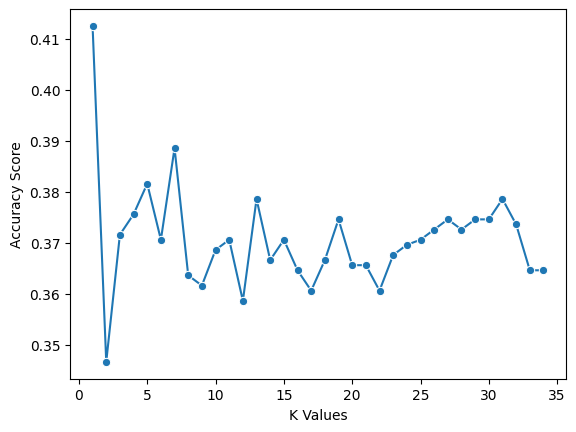

In [ ]:
sns.lineplot(x = k_values, y = scores, marker = 'o')
plt.xlabel("K Values")
plt.ylabel("Accuracy Score")

#plt.savefig('/content/drive/MyDrive/Thesis/Results/knn_k.png')
plt.show()

Train model with best k and evaluate:

In [ ]:
# Train model with best k and evaluate

best_index = np.argmax(scores)
best_k = k_values[best_index]

knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train, np.ravel(y_train))

y_pred = knn.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
accuracies['K-NN'] = accuracy
precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
precisions['K-NN'] = precision
recall = recall_score(y_test, y_pred, average='weighted')
recalls['K-NN'] = recall
f1 = f1_score(y_test, y_pred, average='weighted')
f1_scores['K-NN'] = f1

print("Accuracy for k = {}: {}".format(best_k, accuracy))
print("Precision:", precision)
print("Recall:", recall)
print('F1 score:', f1)

Accuracy for k = 1: 0.39022498060512023
Precision: 0.39015864368683406
Recall: 0.39022498060512023
F1 score: 0.390060600949618


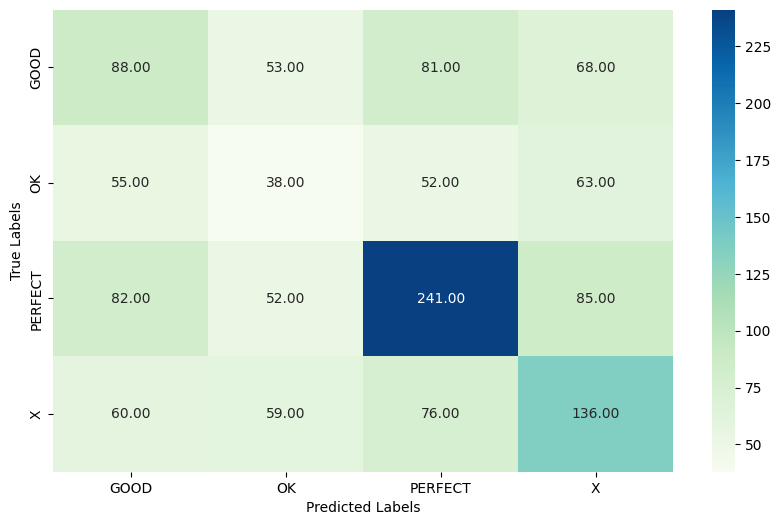

In [ ]:
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(10,6))
fx=sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, fmt=".2f",cmap="GnBu", xticklabels = list(label_encoder.classes_), yticklabels = list(label_encoder.classes_))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")

#plt.savefig('/content/drive/MyDrive/Thesis/Results/knn_conf3.png')
plt.show()

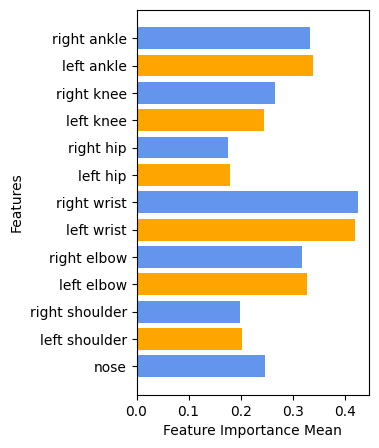

In [ ]:
from sklearn.inspection import permutation_importance

selected_joints = ["nose", "left shoulder", "right shoulder", "left elbow", "right elbow",
                    "left wrist", "right wrist", "left hip", "right hip", "left knee", "right knee", "left ankle",
                    "right ankle"]
# perform permutation importance
results = permutation_importance(knn, X_train, y_train, scoring='accuracy')
# get importance
importance = results.importances_mean

# plot feature importance
plt.figure(figsize=(3,5))
plt.barh([x for x in range(len(importance))], importance, linewidth=3, color=['cornflowerblue','orange'], tick_label=list(selected_joints))
plt.xlabel("Feature Importance Mean")
plt.ylabel("Features")

#plt.savefig('/content/drive/MyDrive/Thesis/Results/knn_feat3.png')
plt.show()

## Support Vector Machine

In [ ]:
from sklearn import svm
from sklearn import metrics

Linear SVM

In [ ]:
# Find best hyperparameters

c_list = [0.01, 0.1, 1, 10, 25, 50, 75, 100]
gamma_list = [0.0001, 0.001, 0.01, 0.1, 1]
best_acc = 0
best_c = 0
best_gamma = 0

for c in c_list:
  for g in gamma_list:
    clf = svm.SVC(kernel='linear', C = c, gamma=g)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    acc = metrics.accuracy_score(y_val, y_pred)
    if acc > best_acc:
      best_acc = acc
      best_c = c
      best_gamma = g

print("Highest accuracy is {}, for C = {} and gamma = {}".format(best_acc, best_c, best_gamma))

Highest accuracy is 0.35664335664335667, for C = 0.01 and gamma = 0.0001


In [ ]:
# Train SVM model for with best hyperparameters
best_c, best_gamma = 0.01, 0.0001

clf = svm.SVC(kernel='linear', C = best_c, gamma=best_gamma)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
accuracies['SVM'] = accuracy
precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
precisions['SVM'] = precision
recall = recall_score(y_test, y_pred, average='weighted')
recalls['SVM'] = recall
f1 = f1_score(y_test, y_pred, average='weighted')
f1_scores['SVM'] = f1

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print('F1 score:', f1)

Accuracy: 0.35686578743211794
Precision: 0.7704874028074277
Recall: 0.35686578743211794
F1 score: 0.18771670922672873


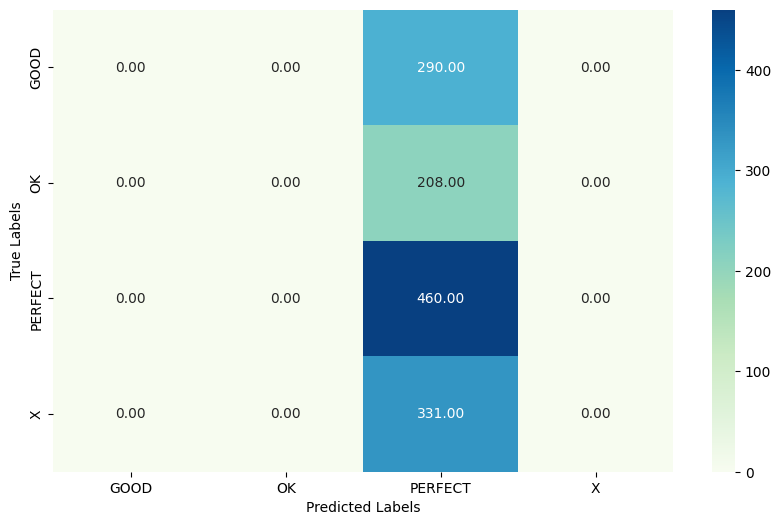

In [ ]:
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(10,6))
fx=sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, fmt=".2f",cmap="GnBu", xticklabels = list(label_encoder.classes_), yticklabels = list(label_encoder.classes_))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")

#plt.savefig('/content/drive/MyDrive/Thesis/Results/svm_conf.png')
plt.show()

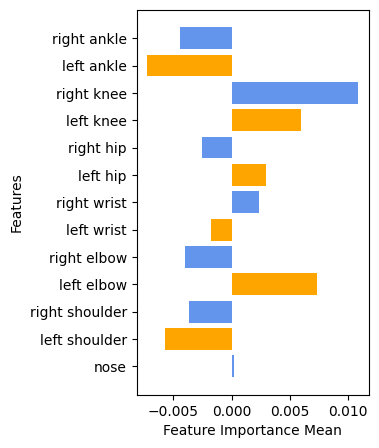

In [ ]:
coefs = clf.coef_
importance = coefs.mean(axis=0)

selected_joints = ["nose", "left shoulder", "right shoulder", "left elbow", "right elbow",
                    "left wrist", "right wrist", "left hip", "right hip", "left knee", "right knee", "left ankle",
                    "right ankle"]

plt.figure(figsize=(3,5))
plt.barh([x for x in range(len(importance))], importance, linewidth=3, color=['cornflowerblue','orange'], tick_label=selected_joints)
plt.xlabel("Feature Importance Mean")
plt.ylabel("Features")

#plt.savefig('/content/drive/MyDrive/Thesis/Results/svm_feat.png')
plt.show()

## Multi-Layer Perceptron

In [ ]:
from sklearn.neural_network import MLPClassifier

In [ ]:
activation_functs = ['identity', 'logistic', 'tanh', 'relu']
layer_sizes_i = [10, 25, 50, 100, 150]
layer_sizes_j = [1,2,3,4,5]

best_acc = 0
best_func = 0
best_size = (0,0)

for func in activation_functs:
  for i in layer_sizes_i:
    for j in layer_sizes_j:
      mlp = MLPClassifier(activation = func, hidden_layer_sizes=(i,j), random_state=1, max_iter=1000)
      mlp.fit(X_train, y_train)
      y_pred = mlp.predict(X_val)
      acc = metrics.accuracy_score(y_val, y_pred)

      if acc > best_acc:
        best_acc = acc
        best_func = func
        best_size = (i,j)

print("Highest accuracy is {}, for activation function {} and layer size = {}".format(best_acc, best_func, best_size))

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:693: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:693: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:693: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:693: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:693: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multil

Highest accuracy is 0.5621546961325967, for activation function relu and layer size = (10, 5)

In [ ]:
from sklearn.neural_network import MLPClassifier

best_func = 'relu'
best_size = (50,5)

mlp = MLPClassifier(activation = best_func, hidden_layer_sizes=best_size, random_state=1, max_iter=1000)
mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
accuracies['MLP'] = accuracy
precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
precisions['MLP'] = precision
recall = recall_score(y_test, y_pred, average='weighted')
recalls['MLP'] = recall
f1 = f1_score(y_test, y_pred, average='weighted')
f1_scores['MLP'] = f1

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 score:", f1)

Accuracy: 0.3716058960434445
Precision: 0.47867374849242245
Recall: 0.3716058960434445
F1 score: 0.2688033895214603


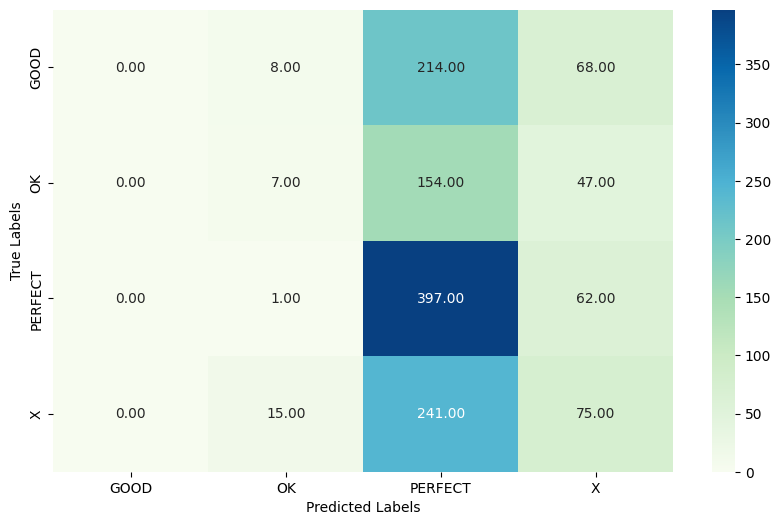

In [ ]:
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(10,6))
fx=sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, fmt=".2f",cmap="GnBu", xticklabels = list(label_encoder.classes_), yticklabels = list(label_encoder.classes_))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")

#plt.savefig('/content/drive/MyDrive/Thesis/Results/mlp_conf.png')
plt.show()

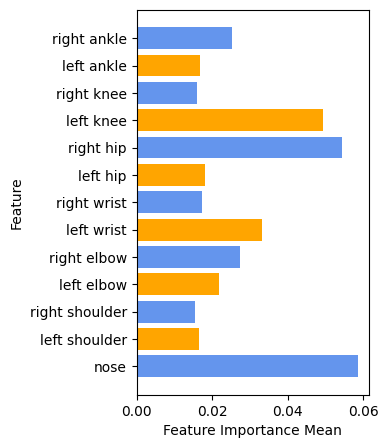

In [ ]:
from sklearn.inspection import permutation_importance

# perform permutation importance
results = permutation_importance(mlp, X_train, y_train, scoring='accuracy')
# get importance
importance = results.importances_mean

# plot feature importance
plt.figure(figsize=(3,5))
plt.barh([x for x in range(len(importance))], importance, linewidth=3, color=['cornflowerblue','orange'], tick_label=list(selected_joints))
plt.xlabel("Feature Importance Mean")
plt.ylabel("Feature")

#plt.savefig('/content/drive/MyDrive/Thesis/Results/mlp_feat.png')
plt.show()

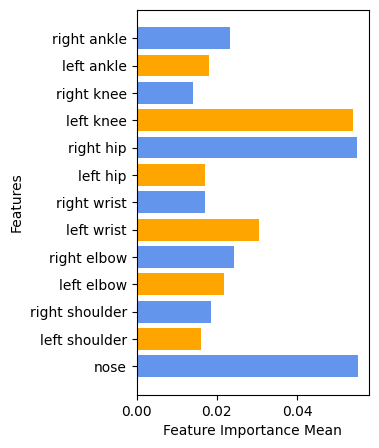

In [ ]:
from sklearn.inspection import permutation_importance

selected_joints = ["nose", "left shoulder", "right shoulder", "left elbow", "right elbow",
                    "left wrist", "right wrist", "left hip", "right hip", "left knee", "right knee", "left ankle",
                    "right ankle"]
# perform permutation importance
results = permutation_importance(mlp, X_train, y_train, scoring='accuracy')
# get importance
importance = results.importances_mean

# plot feature importance
plt.figure(figsize=(3,5))
plt.barh([x for x in range(len(importance))], importance, linewidth=3, color=['cornflowerblue','orange'], tick_label=list(selected_joints))
plt.xlabel("Feature Importance Mean")
plt.ylabel("Features")

#plt.savefig('/content/drive/MyDrive/Thesis/Results/knn_feat3.png')
plt.show()